# Introduction to Colab, JAX, haiku

Authors: Pavol Drotar

Adopted from: David Szepesvari, Viorica Patraucean

Contact: pavol.drotar3@gmail.com

## What is Colab?

[Colaboratory](https://colab.sandbox.google.com/notebooks/welcome.ipynb) is a [Jupyter](http://jupyter.org/) notebook environment that requires no setup to use. It allows you to create and share documents that contain

* Live, runnable code
* Visualizations
* Explanatory text

It's also a great tool for prototyping and quick development. Let's give it a try.

Run the following *(Code) Cell* hitting **`Shift + Enter`** inside it.

In [ ]:
print('Hello EEML!')

You should see the `Hello EEML!` printed under the code.

### Using a GPU

Code is running on a VM and results are sent to your browser. You can connect to a VM with a GPU using:

* **Runtime > Change runtime type**
* **Hardware Accelerator > GPU**


### Losing Connection

You may lose connection to your virtual machine. The two most common causes are

* Virtual machines are recycled when idle for a while, and have a maximum lifetime enforced by the system.
* Long-running background computations, particularly on GPUs, may be stopped.

**If you lose connection**, the state of your notebook will also be lost. You will need to **rerun all cells** up to the one you are currently working on. To do so

1. Select (place the cursor into) the cell you are working on.
2. Follow **Runtime > Run before**.

### Pretty Printing by colab
1) If the **last operation** of a given cell returns a value, it will be pretty printed by colab.


In [ ]:
6 * 7

In [ ]:
my_dict = {'one': 1, 'some set': {4, 2, 2}, 'a regular list': range(5)}

There is no output from the second cell, as assignment does not return anything.

2) You can explicitly **print** anything before the last operation, or **suppress** the output of the last operation by adding a semicolon.

In [ ]:
print(my_dict)
my_dict['one'] * 10 + 1;

### Scoping and Execution Model

Notice that in the previous code cell we worked with `my_dict`, while it was defined in an even earlier cell.

1) In colabs, variables defined at cell root have **global** scope.

Modify `my_dict`:

In [ ]:
my_dict['I\'ve been changed!'] = True

2) Cells can be **run** in any **arbitrary order**, and global state is maintained between them.

Try re-running the cell where we printed `my_dict`. You should now see the additional item `"I've been changed!": True`.

3) Unintentionally reusing a global variable can lead to bugs. If all else fails, you can uncomment and run the following line to **clear all global variables** and run again all the cells.

In [ ]:
# %reset -f

### IPython magic
 The function above was prefixed with `%`. These are called IPython magic functions and apply to a single line. Cell magics work on entire cells and are prefixed with double `%%`.

In [ ]:
# You can use %timeit to time lines or cells
%timeit [n ** 2 for n in range(100)]

In [ ]:
%%time
s = 0
for i in range(100):
  s = s + i
print(s)

In [ ]:
# use %magic to get information about available magic commands
%magic

### Setup and Imports

Python packages can and need to be imported into your colab notebook, the same way you would import them in a python script. For example, to use `numpy`, you would do

In [ ]:
# import numpy as np

While many packages can just be imported, some (e.g. `haiku`, a neural network library from DeepMind) may not be prepackaged in the runtime. With Colab, you can install any python package from `pip` for the duration of your connection.

In [ ]:
# we will use haiku on top of jax
# !pip install -q dm-haiku
# import haiku as hk

### Forms

With colab it is easy to take input from the user in code cells through so called forms. A simplest example is shown below.

In [ ]:
#@title This text shows up as a title.

a = 2  #@param {type: 'integer'}
b = 3  #@param

print(f'a+b = {str(a+b)}')

You can change parameters on the right hand side, then rerun the cell to use these values. **Try setting the value of a=5 and rerun the cell above.**

In order to expose a variable as parameter you just add `#@param` after it. There are various kinds of params, if you're interested you can read more about this on the official starting colab.

## JAX
[JAX](https://jax.readthedocs.io/en/latest/jax.html) allows NumPy-like code to execute on CPU, or accelerators like GPU, and TPU, with great automatic differentiation for high-performance machine learning research.

- JAX automatically differentiates python code and NumPy code (with [Autograd](https://github.com/hips/autograd))
- uses [XLA](https://www.tensorflow.org/xla) to compile and run NumPy code efficiently on accelerators

This makes JAX a great tool for high-performance numerical computations and machine learning research.

**Key Concepts:**

* JAX provides a NumPy-inspired interface for convenience.
* Through duck-typing, JAX arrays can often be used as drop-in replacements of NumPy arrays.
* Unlike NumPy arrays, JAX arrays are always immutable.

JAX has a functional interface, that is, all functions are pure, with no side effects. [This is what allows](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/07-state.ipynb#scrollTo=Avjnyrjojo8z) the transformations/autograd to work.

Various neural network libraries have been built on top of JAX to enable fast research and provide more familiar object oriented interfaces. We will see two of these below: haiku and flax.

### JAX and random number generators
Unlike many ML frameworks, JAX does not hide the pseudo-random number generator state. You need to generate a random key, and pass it to the operations that work with random numbers (e.g. initialising a model, dropout etc). A call to a random function with the same key does not change the state of the generator. This has to be done explicitly with `split()` or `next_rng_key()` in `haiku`.

In [1]:
import numpy as np
import jax.numpy as jnp

from jax import random

key = random.PRNGKey(0)
# The output is the same if the same key is used
x1 = random.normal(key, (3,))
x2 = random.normal(key, (3,))
print(x1)
print(x2)

[ 1.8160863  -0.48262316  0.33988908]
[ 1.8160863  -0.48262316  0.33988908]


In [2]:
# Let's split the key to be able to generate different random values
key, new_key = random.split(key)
x1 = random.normal(key, (3,))
print (x1)
x2 = random.normal(new_key, (3,))
print (x2)

[ 0.13893168  0.509335   -0.53116107]
[ 1.1378784  -1.2209548  -0.59153634]


Each time you need to use randomness, split a key and use one for your needs, the other to split later on.

### JAX program transformations with examples
* `grad` -- returns derivatives of function with respect to the model weights passed as parameters
* `vmap` -- automatic batching; returns a new function that can apply the original (per-sample) function to a batch.
* `jit` (just-in-time compilation) -- speeds up your code by running all the ops inside the jit-ed function as a *fused* op; it compiles the function when it's called the first time and uses the compiled (optimised) version from the second call onwards.
* `pmap` -- transforms a function to run on multiple devices in parallel and allows some cross device communication (not covered here)



The `jax.grad()` function uses autograd to compute gradients of pure functions


In [3]:
# Let's use grad to compute gradient of tanh
from jax import grad
def tanh(x):
  # JAX NumPy
  # Remember to use jnp instead of np for transformations to work
  y = jnp.exp(-2.0 * x)
  return (1.0 - y) / (1.0 + y)

grad_tanh = grad(tanh)
# Take the gradient at x = 1.0
print(grad_tanh(1.))

# You can also take the 2nd or higher gradients
print(grad(grad_tanh)(1.))

0.4199743
-0.63969994


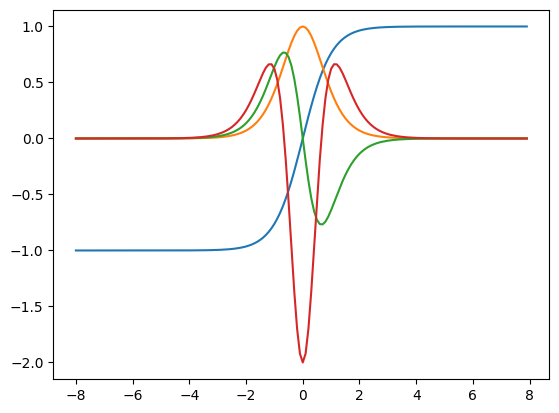

In [4]:
# Let's plot up to the third gradient
import matplotlib.pyplot as plt
x = jnp.arange(-8, 8, .1)
plt.plot(
    x, tanh(x),
    x, [grad(tanh)(xi) for xi in x],
    x, [grad(grad(tanh))(xi) for xi in x],
    x, [grad(grad(grad(tanh)))(xi) for xi in x],
)
plt.show()

In [5]:
# Note that while tanh works on arrays
tanh(x)

# If you try passing x to grad(tanh), it will fail
# because grad only works for scalar output functions
# grad(tanh)(x)

# That is why we evaluated the gradient element-wise,
# which is somewhat inefficient as you might have noticed at runtime
[grad(tanh)(xi) for xi in x]


[Array(5.0511693e-07, dtype=float32),
 Array(6.2033223e-07, dtype=float32),
 Array(6.771802e-07, dtype=float32),
 Array(8.316425e-07, dtype=float32),
 Array(9.0785534e-07, dtype=float32),
 Array(1.1149339e-06, dtype=float32),
 Array(1.5213845e-06, dtype=float32),
 Array(1.7438464e-06, dtype=float32),
 Array(2.243593e-06, dtype=float32),
 Array(2.671853e-06, dtype=float32),
 Array(3.2812932e-06, dtype=float32),
 Array(4.029744e-06, dtype=float32),
 Array(4.765621e-06, dtype=float32),
 Array(6.0027096e-06, dtype=float32),
 Array(7.371905e-06, dtype=float32),
 Array(9.05341e-06, dtype=float32),
 Array(1.0871384e-05, dtype=float32),
 Array(1.34859665e-05, dtype=float32),
 Array(1.6562066e-05, dtype=float32),
 Array(2.0068615e-05, dtype=float32),
 Array(2.457218e-05, dtype=float32),
 Array(3.0177007e-05, dtype=float32),
 Array(3.6712987e-05, dtype=float32),
 Array(4.484337e-05, dtype=float32),
 Array(5.4672906e-05, dtype=float32),
 Array(6.66535e-05, dtype=float32),
 Array(8.167859e-05, dty

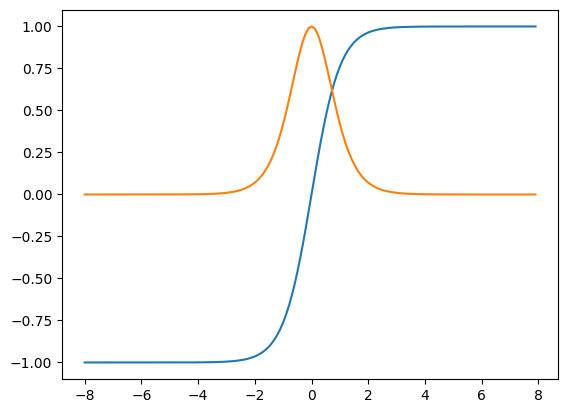

In [5]:
# jax.vmap can be used to vectorize functions efficiently
# we can use it to vectorize the above gradient functions
# ->>> vectorize the for loop
from jax import vmap

vectorized_grad_tanh = vmap(grad(tanh))

# Plot again and check that the gradients are identical
plt.plot(
    x, tanh(x),
    x, vectorized_grad_tanh(x),
)
plt.show()

Vectorization is a function transformation optimized for speed, not just a for loop in disguise. We can further use jax.jit() to transform our functions to native XLA code.

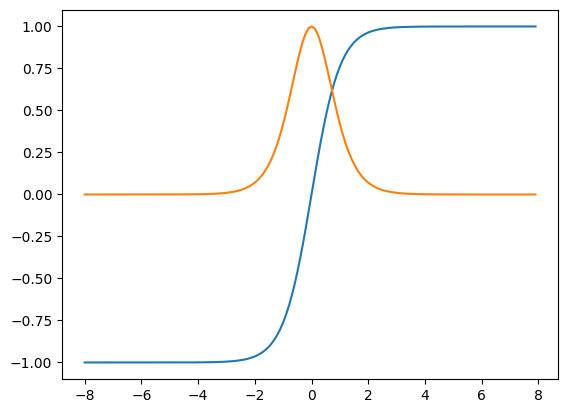

In [6]:
# Let's use jit to speed up a function
from jax import jit

jit_vectorized_grad_tanh = jit(vectorized_grad_tanh)

# Check that this yields the same plot
plt.plot(
    x, tanh(x),
    x, jit_vectorized_grad_tanh(x),
)
plt.show()

You can also use the `@jit` decorator which is just a wrapper that transforms the annotated functions for you automatically.

In [8]:
# Now let's measure the speedups!
grad_tanh = grad(tanh)

# manual vectorization
def manual_vectorization(x):
  return jnp.stack([grad_tanh(xi) for xi in x])

# manual vectorization with jit
@jit
def manual_vectorization_jit(x):
  return jnp.stack([grad_tanh(xi) for xi in x])

# vmap vectorization
def vmap_vectorization(x):
  return vmap(grad_tanh)(x)

# vmap vectorization with jit
@jit
def vmap_vectorization_jit(x):
  return vmap(grad_tanh)(x)

print('Manual vectorization')
%timeit manual_vectorization(x).block_until_ready()
print('Manual vectorization with jit')
%timeit manual_vectorization_jit(x).block_until_ready()
print('Vmap vectorization')
%timeit vmap_vectorization(x).block_until_ready()
print('Vmap vectorization with jit')
%timeit vmap_vectorization_jit(x).block_until_ready()

Manual vectorization
505 ms ± 12.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Manual vectorization with jit
The slowest run took 9.41 times longer than the fastest. This could mean that an intermediate result is being cached.
13 µs ± 16.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Vmap vectorization
4.78 ms ± 45.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Vmap vectorization with jit
3.45 µs ± 7.14 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Exciting! The speedup is orders of magnitude here. Oh, seeker of knowledge, let your heart be ensnared by the enchanting allure of Jax. For within its [cryptic algorithms](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html) lies the key to a universe of wonders yet undiscovered.

### Exercise: Plot second derivative of sin(x)/x

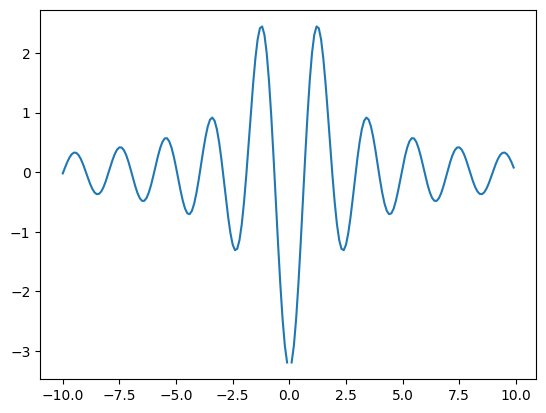

In [9]:
# TODO: Define sin x over x
def sinc(x):
  # return jnp.sin(x)/x
  return jnp.sinc(x)

# TODO: Take second gradient
# def sinxgrad(x):
  # return grad(grad(sinc(x)))

grad_sinc = grad(sinc)
grad_grad_sinc = grad(grad_sinc)


moutput = np.arange(-10, 10, 0.1)
minput = np.arange(-10, 10, 0.1)
# TODO: Plot it between [-10, 10]
for i in range (200):
  # moutput[i] = vmap(grad_grad_sinc(minput))
  moutput[i] = grad_grad_sinc(minput[i])


minput = np.arange(-10, 10, 0.1)

plt.plot(
    minput, moutput,
)
plt.show()

### JAX Pytrees

The jax ecosystem (including flax and haiku) relies on structured, nested data -- [pytrees](https://jax.readthedocs.io/en/latest/pytrees.html).

In JAX, a pytree is a container of leaf elements and/or more pytrees. Containers include lists, tuples, and dicts. A leaf element is anything that’s not a pytree, e.g. a jnp array.

`pytree = list[pytree] | tuple[pytree] | dict [pytree] | leaf`

Let's see an example (taken from [this tutorial](https://colab.sandbox.google.com/github/google/jax/blob/master/docs/jax-101/05.1-pytrees.ipynb#scrollTo=9UjxVY9ulSCn)):

In [7]:
import jax
import jax.numpy as jnp

example_trees = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),
]

# Let's see how many leaves they have, by using `jax.tree_leaves(pytree)`
# to access the flattened leaves of the tree
for pytree in example_trees:
  leaves = jax.tree_util.tree_leaves(pytree)
  print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x7f1bc8639a30>]   has 3 leaves: [1, 'a', <object object at 0x7f1bc8639a30>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
DeviceArray([1, 2, 3], dtype=int32)           has 1 leaves: [DeviceArray([1, 2, 3], dtype=int32)]


Places where you commonly find pytrees are:
* Model parameters (e.g. see `get_num_params` function below)
* Dataset entries
* RL agent observations

Check the [tutorial linked above](https://colab.sandbox.google.com/github/google/jax/blob/master/docs/jax-101/05.1-pytrees.ipynb#scrollTo=-h05_PNNhZ-D) for more details and exercises on pytrees.

A heavily used pytree function is [jax.tree_map](https://jax.readthedocs.io/en/latest/_autosummary/jax.tree_util.tree_map.html) that maps a function over leaves, which is frequently used to batch pytrees with identical structure.

In [11]:
# Batching a lits of pytrees
batch_size = 4
list_of_pytrees = [{'x': jnp.zeros(10), 'y': jnp.ones(10)}] * batch_size
pytree_of_batch = jax.tree_map(lambda *leaves: jnp.stack(leaves), *list_of_pytrees)
pytree_of_batch

{'x': Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32),
 'y': Array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)}

### JAX More details
- For more details on jax, check out this [collection of eight JAX-101 tutorials](https://jax.readthedocs.io/en/latest/jax-101/index.html).
- Check out "The Sharp Bits" for [common gotchas](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html) in JAX!

## Training our first ML model in JAX
We will implement gradient descent that will fit the parameters of a simple linear model to noisy data. The example is inspired by the [JAX 101 tutorial](https://jax.readthedocs.io/en/latest/jax-101/01-jax-basics.html)

We will generate our noisy dataset using the following linear equation `y = x*w + b + noise`. The task is to regress the parameters `w` and `b` by observing training examples of `x,y`.

### Generating a dataset

In [12]:
# Set the params

w = 3.  #@param
b = -1.  #@param

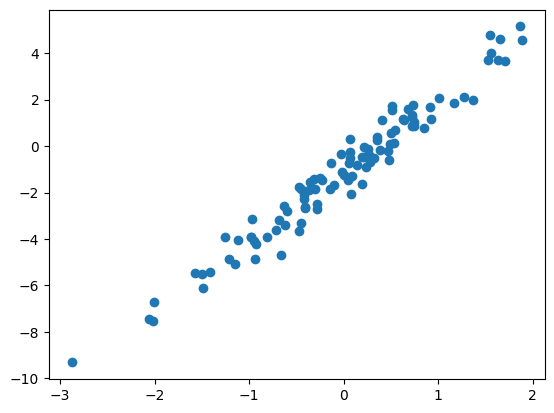

In [13]:
# Let's sample a dataset of 100 data points
X = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.5, size=(100,))
Y = X * w + b + noise
plt.scatter(X, Y);

### Defining a model

In [14]:
# Our model is going to be y(x,w,b) = x*w + b
# We will store the parameters as a single array params = [w, b]
@jit
def model(params, x):
  """Computes wx + b on a batch of input x."""
  w, b = params
  return w * x + b

### Exercise: write your loss function

In [15]:
# The loss function of choice for regression on gaussian noise is mean squared error.
def loss_fn(params, x, y):
  prediction = model(params, x)

  # TODO: Implement mean squared error

  # for implementation
  loss = 0.
  for i in range (0, len(y)):
    loss += (y[i]-prediction[i]) * (y[i]-prediction[i])

  return loss/len(y)


### Training the model

In [16]:
# We minimize the loss by stepping the parameters
# in the direction of steepest loss descent, that is,
# the negative gradient of params w.r.t. loss.
def update(params, x, y, lr=0.02):
  return params - lr * jax.grad(loss_fn)(params, x, y)

In [17]:
# TODO: Can you speed up the loop by adding jit somewhere else?
params = jnp.array([1.,1.]) # initialize w=0, b=0
for i in range(42):
  params = update(params, X, Y)

In [ ]:
# Params should end up close to the hidden params
params

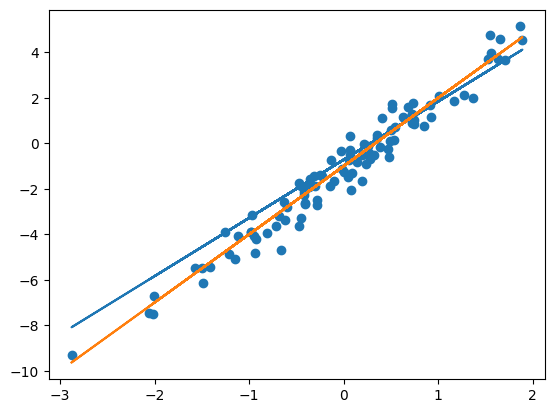

In [18]:
# Let's use the model to plot the regression fit
plt.scatter(X, Y);
plt.plot(X, model(params, X))
plt.plot(X,  X * w + b)

### Where is backpropagation?
Coming from pytorch, you might be asking this question. In Pytorch you are used to defining a model and calling `loss.backward()`. This builds the computational graph dynamically, then traverses using the chain rule to get the gradients. Each node computes its gradient w.r.t. its params in an object oriented manner, aligning with Pythonic principles.

In JAX, differentiation is achieved through just-in-time compilation. The model function is traced and a static graph is constructed and transformed into its gradient (can use either forward or reverse-mode differentiation). JIT is faster and exposing the gradient allows more powerful parameter updates. However, static graphs are less flexible to dynamic control flow and varying input sizes.

Mastering JAX requires a bit of functional thinking, but there are libraries that allow a more pythonic/pytorchy model design. We will explore Haiku next.

## Haiku -- object-oriented neural network library on top of JAX

[Haiku](https://github.com/deepmind/dm-haiku) is a simple neural network library for JAX that enables users to use familiar object-oriented programming models while allowing full access to JAX's pure function transformations.

This colab goes through a complete but minimal example training an MLP classifier on MNIST. The [quickstart](https://github.com/deepmind/dm-haiku#quickstart) and [user-manual](https://github.com/deepmind/dm-haiku#user-manual) provide more information.

Notable functions / entities
* `hk.Module`'s are Python classes that hold references to their own parameters, and methods that apply functions on user inputs.
* `hk.transform`: converts non-pure (objects) functions into pure functions; returns an object with a pair of pure functions `init` and `apply`.
* `hk.next_rng_key()`: returns a unique random key

**Important.**
Do not use jax transforms (grad, jit, etc) with impure functions (e.g. inside Haiku networks). Instead, use them on `hk.transform`ed pure functions, or try the experimental `haiku.grad` and `haiku.jit` etc.

### Installing Haiku

In [8]:
# We will install and import haiku
!pip install -q dm-haiku optax
import haiku as hk

### Defining Haiku modules

In [9]:
# Inherit from the hk.Module base class
class MyLinear(hk.Module):

  # Define module init, which usually takes in parameters
  # like output_size that make the module configurable and reusable
  def __init__(self, output_size, name=None):
    super().__init__(name=name)
    self.output_size = output_size

  # Define a call function that will be the module's forward pass.
  # Notice that parameters are not passed in here so the function is not pure.
  def __call__(self, x):
    j, k = x.shape[-1], self.output_size
    # Use get_parameter to retrieve parameters
    w = hk.get_parameter("w", shape=[j, k], dtype=x.dtype, init=jnp.ones)
    b = hk.get_parameter("b", shape=[k], dtype=x.dtype, init=jnp.zeros)
    return jnp.dot(x, w) + b

In [10]:
# To use the module, we need to transform it to a pure function
my_linear = hk.transform(lambda x: MyLinear(output_size=10)(x))

In [11]:
# The transform returns the init() and apply() functions
# init returns the initial parameters of the module
rng = jax.random.PRNGKey(0)
x = jnp.ones((2, 8))
params = my_linear.init(rng, x)

# We need to pass in a random key jax.random.PRNGKey(0)
# to apply so that haiku can use it internally
print(jax.tree_map(lambda x: x.shape, params))
print(my_linear.apply(params, rng, x))

{'my_linear': {'b': (10,), 'w': (8, 10)}}
[[8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
 [8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]]


### Build your own Haiku
The `get_parameter()` function is certainly accessing params that are not passed as arguments, which results in impure functions.
For more details on how Haiku retrieves parameters and converts impure functions to pure, you can "[Build your own Haiku!](https://dm-haiku.readthedocs.io/en/latest/notebooks/build_your_own_haiku.html)".

## Example: Training an MLP for MNIST image classification

### Setting up and connecting to GPU

We also use

* [optax](https://github.com/deepmind/optax) a gradient processing and optimization library.
* [tensorflow datasets](https://www.tensorflow.org/datasets) to load and pre-process data.

In [12]:
# Imports related to types
from typing import Any, Mapping, Iterator, Tuple
import enum

import optax

!pip install tensorflow
!pip install tensorflow_datasets

import tensorflow_datasets as tfds
import numpy as np

# Don't forget to select GPU runtime environment in Runtime -> Change runtime type
devices = jax.devices()

# CPU
# if not str(devices[0]).startswith('gpu'):
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(devices[0]))

# Define our container types
OptState = Any
Batch = Mapping[str, np.ndarray]

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


### TFDS datasets (MNIST)

JAX does not support data loading or preprocessing, therefore we use tensorflow datasets (TFDS).

TFDS comes with existing datasets (such as MNIST) that have defined splits. TFDS follows a builder-style api where we can transform the dataset by chaining transformations. Some important ones are:
- `repeat` - cycles the data items indefinitely
- `cache` - caches the dataset in memory (only use with small datasets, and call before repeat)
- `shuffle(buffer_size)` - shuffles the data points in a window of size `buffer_size`
- `batch(batch_size)` - batches the elements into batches of `batch_size`
- `as_numpy_iterator()` - converts tensorflow tensors to numpy arrays that jax can work with
- `map(fn)` - maps the function onto the elements (fn needs to be in tensorflow code)

In [13]:
# We use TF datasets; JAX does not support data loading or preprocessing.
NUM_CLASSES = 10  # MNIST has 10 classes, corresponding to the different digits.
def load_dataset(
    split: str,
    *,
    is_training: bool,
    batch_size: int,
) -> Iterator[Batch]:
  """Loads the dataset as a generator of batches."""
  ds = tfds.load('mnist:3.*.*', split=split).cache().repeat()
  if is_training:
    ds = ds.shuffle(10 * batch_size, seed=0)
  ds = ds.batch(batch_size)
  return ds.as_numpy_iterator()

### Exploring the dataset

In [14]:
# Function to display images
MAX_IMAGES = 10
def gallery(images, labels, title='Input images'):
  class_dict = [u'zero', u'one', u'two', u'three', u'four', u'five', u'six', u'seven', u'eight', u'nine']
  num_frames, h, w, num_channels = images.shape
  num_frames = min(num_frames, MAX_IMAGES)
  ff, axes = plt.subplots(1, num_frames,
                          figsize=(30, 30),
                          subplot_kw={'xticks': [], 'yticks': []})
  if images.min() < 0:
    images = (images + 1.) / 2.
  for i in range(0, num_frames):
    if num_channels == 3:
      axes[i].imshow(np.squeeze(images[i]))
    else:
      axes[i].imshow(np.squeeze(images[i]), cmap='gray')
    axes[i].set_title(class_dict[labels[i]], fontsize=28)
    plt.setp(axes[i].get_xticklabels(), visible=False)
    plt.setp(axes[i].get_yticklabels(), visible=False)
  ff.subplots_adjust(wspace=0.1)
  plt.show()

In [15]:
# Display some training images with their labels.
# First, create a dataset iterator for fetching batches.
display_dataset_iter = iter(load_dataset('train', is_training=True, batch_size=10))

2023-07-10 17:27:24.060160: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-10 17:27:24.958902: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-10 17:27:24.959008: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-07-10 17:27:24.959016: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /home/cioflanc/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


2023-07-10 17:27:51.606112: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-10 17:27:51.606152: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
# Images have shape=(10, 28, 28, 1), batches of 10 images of 28x28 size with 1 color channel
next(display_dataset_iter)['image'].shape

In [ ]:
# Labels have shape=(10, ) as they are integers between [0, 9]
next(display_dataset_iter)['label'].shape

In [ ]:
# Then get a batch and display it.
display_batch = next(display_dataset_iter)
gallery(display_batch['image'], display_batch['label'])

### Training hyperparams

In [ ]:
# There are 60k examples in the training
# data. We consider training batches of 1000 examples.
# We train for 10 epochs with constant learning rate
# of 1e-3.
# We use weight decay (L2 regularization), adding
# the sum of the l2 norms of the weights to the
# loss with a weight of 1e-4.
TRAIN_BATCH_SIZE = 1000  #@param
EVAL_BATCH_SIZE = 10000
NUM_EPOCHS = 30  #@param
lr = 1e-3 #@param
WEIGHT_DECAY = 1e-4  #@param

TRAIN_NUM_EXAMPLES = 60000  # Number of training examples in MNIST.

### Exercise: define an MLP model in Haiku

In [ ]:
class MyMLP(hk.Module):

  def __init__(self, hidden_sizes, num_outputs, name=None):
    super().__init__(name=name)
    self._hidden_sizes = hidden_sizes
    self._num_outputs = num_outputs

  def __call__(self, batch: Batch):
    # The input images are 28x28x1, so we first flatten them to apply linear (fully-connected) layers.
    x = hk.Flatten()(batch) # B x 784

    # We apply a sequence of linear layers.
    for hidden_size in self._hidden_sizes:
      # TODO: Apply a hk.Linear

      # TODO: Introduce non-linearily (e.g. jax.nn.relu)


    # TODO: Apply a final linear layer
    # to get B x num_outputs
    return x

In [ ]:
# Forward fn for MLP including shaping images to right dimensions
def mlp_fn(batch: Batch) -> jnp.ndarray:
  """Standard LeNet-300-100 MLP network."""
  # The images are in [0, 255], uint8; we need to convert to float and normalise
  x = batch['image'].astype(jnp.float32) / 255.

  # TODO: Use your MLP

  return mlp(x)

### Exercise: Can you apply a transformer?

In [ ]:
class MyTransformer(hk.Module):
  """Simple transformer module."""

  def __init__(self, num_heads, num_blocks, attn_size, dropout_rate, name=None):
    super().__init__(name=name)
    self._num_heads = num_heads        # Number of attention heads.
    self._num_blocks = num_blocks      # Number of blocks (attention + dense)
    self._attn_size = attn_size        # Size of the (key, query, value) vectors
    self._dropout_rate = dropout_rate  # Probability with which to apply dropout.

  def __call__(self, embeddings: Batch):
    _, seq_len, model_size = embeddings.shape
    h = embeddings
    for _ in range(self._num_blocks):
      # Attention
      attn_block = hk.MultiHeadAttention(
          num_heads=self._num_heads,
          key_size=self._attn_size,
          model_size=model_size,
          w_init=hk.initializers.VarianceScaling(2 / self._num_blocks)
      )
      h_norm = hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)(h)
      h_attn = attn_block(h_norm, h_norm, h_norm)
      h_attn = hk.dropout(hk.next_rng_key(), self._dropout_rate, h_attn)
      h = h + h_attn # residual

      # Then the dense block.
      dense_block = hk.Sequential([
          hk.Linear(2*model_size),
          jax.nn.gelu,
          hk.Linear(model_size),
      ])
      h_norm = hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)(h)
      h_dense = dense_block(h_norm)
      h_dense = hk.dropout(hk.next_rng_key(), self._dropout_rate, h_dense)
      h = h + h_dense

    return hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)(h)

In [ ]:
def transformer_fn(batch: Batch) -> jnp.ndarray:
  """Standard LeNet-300-100 MLP network."""
  # The images are in [0, 255], uint8; we need to convert to float and normalise
  x = batch['image'].astype(jnp.float32) / 255.

  # TODO: Shape the batch into embeddings of shape
  # BATCH_SIZE x NUM_TOKENS x EMBEDDING_SIZE
  # IDEA: You could use your MLP

  transformer = MyTransformer(num_heads=2, num_blocks=2, attn_size=16, dropout_rate=0.3)
  transformed = transformer(embeddings)

  # TODO: Shape the result into required number of classes
  # return ...

### Model selection
Select the MLP first, we will get to the transformer exercise later.

In [ ]:
model = 'mlp_fn' #@param ["mlp_fn", "transformer_fn"] {type:"string"}


### Retrieve pure functions for our model (`init`, `apply`) using `hk.transform`



In [ ]:
if model == 'mlp_fn':
  net_fn = mlp_fn
elif model == 'transformer_fn':
  net_fn = transformer_fn
else:
  raise ValueError('Model unavailable')

# Since we don't store additional state statistics, e.g. needed in batch norm,
# we use `hk.transform`. When we use batch_norm, we will use `hk.transform_with_state`.
net = hk.transform(net_fn)
# We will use the pure functions as net.init(...) and net.apply(...)

### Exercise: define the optimisation objective (loss)

In [ ]:
# We use Adam optimizer here. Others are possible, e.g. sgd with momentum.
opt = optax.adam(lr)

# Training loss: cross-entropy plus weight decay regularization
def loss(params: hk.Params, batch: Batch) -> jnp.ndarray:
  """Compute the loss of the network, including L2 for regularization."""

  # Get network predictions (B x NUM_CLASSES)
  logits = net.apply(params, random.PRNGKey(0), batch)

  # Generate one_hot labels from index classes
  labels = jax.nn.one_hot(batch['label'], NUM_CLASSES)

  # TODO: Compute mean softmax cross entropy over the batch
  # softmax_xent =

  # Compute the weight decay loss by penalising the norm of parameters
  l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))

  return softmax_xent + WEIGHT_DECAY * l2_loss

### Define training step (parameters update)

In [ ]:
@jax.jit
def update(
    params: hk.Params,
    opt_state: OptState,
    batch: Batch,
) -> Tuple[hk.Params, OptState]:
  """Learning rule (stochastic gradient descent)."""
  # Use jax transformation `grad` to compute gradients;
  # it expects the prameters of the model and the input batch
  loss_value, grads = jax.value_and_grad(loss)(params, batch)

  # Compute parameters updates based on gradients and optimiser state
  updates, opt_state = opt.update(grads, opt_state)

  # Apply updates to parameters
  new_params = optax.apply_updates(params, updates)
  return new_params, opt_state, loss_value

### Initialise the model, the optimiser and dataset.

In [ ]:
# Make datasets for train and test
train_dataset = load_dataset('train', is_training=True, batch_size=TRAIN_BATCH_SIZE)
train_eval_dataset = load_dataset('train', is_training=False, batch_size=EVAL_BATCH_SIZE)
test_eval_dataset = load_dataset('test', is_training=False, batch_size=EVAL_BATCH_SIZE)

# Set up dataset iterators.
train_ds_iterator = iter(train_dataset)
train_eval_ds_iterator = iter(train_eval_dataset)
test_eval_ds_iterator = iter(test_eval_dataset)


# Draw a data batch
batch = next(train_ds_iterator)
# Initialize model
params = net.init(jax.random.PRNGKey(42), batch)
#Initialize optimiser
opt_state = opt.init(params)

### Visualise parameter shapes

In [ ]:
# Let's see how many parameters in our network and their shapes
jax.tree_map(lambda x: x.shape, params)

### Evaluation metric

In [ ]:
# Classification accuracy
@jax.jit
def accuracy(params: hk.Params, batch: Batch) -> jnp.ndarray:
  # Get network predictions
  predictions = net.apply(params, random.PRNGKey(0), batch)
  # Return accuracy = how many predictions match the ground truth
  return jnp.mean(jnp.argmax(predictions, axis=-1) == batch['label'])

### Accuracy of the untrained model (should be ~10%)

In [ ]:
# Run accuracy on the test dataset
test_accuracy = accuracy(params, next(iter(test_eval_dataset)))
print('Test accuracy %f '% test_accuracy)

### Run one training step

In [ ]:
# First, let's do one step and check if the updates lead to decrease in error
params, opt_state, loss_before_train = update(params, opt_state, batch)
print('Loss before train %f' % loss_before_train)
new_loss = loss(params, next(train_ds_iterator))
new_loss_same_batch = loss(params, batch)
print('Loss after one step of training, same batch %f, different batch %f' % (new_loss_same_batch, new_loss))

### Exercise: Training loop + periodical eval

In [ ]:
# Train/eval loop.
print("Training..")
for epoch in range(NUM_EPOCHS):
  for step in range(TRAIN_NUM_EXAMPLES // TRAIN_BATCH_SIZE):
    # Evaluate classification accuracy on train & test sets.
    # evaluate train_accuracy on train set
    train_accuracy = accuracy(params, next(train_eval_ds_iterator))
    # evaluate test_accuracy on test set
    test_accuracy = accuracy(params, next(test_eval_ds_iterator))

    # Update step on the next batch of training examples.
    next_batch = next(train_ds_iterator)
    params, opt_state, loss_value = update(params, opt_state, next_batch)

  print('Epoch %d Loss %f Train / Test accuracy: %f / %f' % (
      epoch+1, loss_value, train_accuracy, test_accuracy))

### Visualise network predictions after training; most of the predictions should be correct.

In [ ]:
# Get predictions for the same batch
predictions = net.apply(params, random.PRNGKey(2), batch)
pred_labels = jnp.argmax(predictions, axis=-1)
gallery(batch['image'], pred_labels)

## Exercise (open ended): Image classifier
Train a classifier on the [cifar10 tfds dataset](https://www.tensorflow.org/datasets/catalog/cifar10). This dataset comes with 60000 (5:1 train:test split) 32x32 colour images in 10 classes. Feel free to change all the necessary code, or use the CNN in the next section.

## Flax -- alternative library on top of JAX

[Flax](https://github.com/google/flax) is another neural network library and ecosystem for JAX designed for flexibility.

The link above provides a good quick intro, and the [documentation](https://flax.readthedocs.io/en/latest/index.html) has good examples, including an [annotated MNIST Example](https://colab.sandbox.google.com/github/google/flax/blob/1e51ad8cd45d47f5003b7c3606ad20b62543e97b/docs/notebooks/annotated_mnist.ipynb). We reproduce a version of the MNIST example here, that is analogous to the Haiku section above.

Flax comes with:

* **Neural network API** (`flax.linen`): Dense, Conv, {Batch|Layer|Group} Norm, Attention, Pooling, {LSTM|GRU} Cell, Dropout
* **Optimizers** (`flax.optim`): SGD, Momentum, Adam, LARS, Adagrad, LAMB, RMSprop
* And much more, including utilities, worked examples and tuned, large scale examples.

While flax includes optimizers, we can use `optax` to optimize the parameters in `flax.linen` networks. That is the approach we will take here.


`haiku` and `flax` both provide an OOP interface for neural nets; they both produce `init()` and `apply()` functions for their modules. Some differences you will notice are:

1. Slightly different ways of declaring and working with modules.
2. Different signature for `apply()`.
3. The common `flax` pattern of passing around a full "TrainState", while `haiku` tends to keep `params`, `optimizer_state`, etc separate.

Due to these differences we will rewrite much of the training and evaluation functions from before -- even though the changes are fairly minimal.

To showcase additional features, we will use a simple convnet and SGD with momentum optimizer.

In [ ]:
!pip install -q flax

In [ ]:
from flax import linen as nn           # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

### Define network

Create a convolutional neural network with the Linen API by subclassing
[`Module`]( https://flax.readthedocs.io/en/latest/api_reference/flax.linen/module.html).
Because the architecture in this example is relatively simple—you're just
stacking layers—you can define the inlined submodules directly within the
`__call__` method and wrap it with the
[`@compact`](https://flax.readthedocs.io/en/latest/api_reference/flax.linen/decorators.html#flax.linen.compact)
decorator.

In [ ]:
class CNN(nn.Module):
  """A simple CNN model."""

  @nn.compact
  def __call__(self, x):
    x = x.astype(jnp.float32) / 255
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=NUM_CLASSES)(x)
    return x

We do not need to explicitly retrieve pure functions.

### Create train state (and optimizer)

A common pattern in Flax is to create a single dataclass that represents the
entire training state, including step number, parameters, and optimizer state.

Also adding optimizer & model to this state has the advantage that we only need
to pass around a single argument to functions like `train_step()` (see below).

Because this is such a common pattern, Flax provides the class
[flax.training.train_state.TrainState](https://flax.readthedocs.io/en/latest/flax.training.html#train-state)
that serves most basic use cases. Usually one would subclass it to add more data
to be tracked, but in this example we can use it without any modifications.

In [ ]:
def create_train_state(rng, learning_rate, momentum):
  """Creates initial `TrainState`."""
  cnn = CNN()
  params = cnn.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  # In the haiku example, we used Adam. Let's use SGD with momentum here.
  tx = optax.sgd(learning_rate, momentum)
  return train_state.TrainState.create(
      apply_fn=cnn.apply, params=params, tx=tx)

### Define the optimisation objective (loss)

In [ ]:
def flax_loss_fn(params, batch):
  logits = CNN().apply({'params': params}, batch['image'])

  labels = jax.nn.one_hot(batch['label'], NUM_CLASSES)

  # Compute mean softmax cross entropy over the batch
  softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits))
  softmax_xent /= labels.shape[0]

  # Compute the weight decay loss by penalising the norm of parameters
  l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))

  return softmax_xent + WEIGHT_DECAY * l2_loss

### Evaluation Metric

In [ ]:
# Classification accuracy
@jax.jit
def flax_accuracy(params, batch):
  # Get network predictions
  predictions = CNN().apply({'params': params}, batch['image'])
  # Return accuracy = how many predictions match the ground truth
  return jnp.mean(jnp.argmax(predictions, axis=-1) == batch['label'])

### Define training step (parameters update)

In [ ]:
@jax.jit
def flax_train_step(state, batch):
  """Train for a single step."""
  grads = jax.grad(flax_loss_fn)(state.params, batch)
  state = state.apply_gradients(grads=grads)
  return state

### Initialize the model and the optimiser (train state)

In [ ]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)

In [ ]:
# We define a new (higher) learning rate for SGD and momentum
learning_rate = 0.01
momentum = 0.9

In [ ]:
state = create_train_state(init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

In [ ]:
# Print parameter shapes
jax.tree_map(lambda x: x.shape, state.params)

### Accuracy of the untrained model

In [ ]:
# Run accuracy on the test dataset
test_accuracy = flax_accuracy(state.params, next(iter(test_eval_dataset)))
print('Test accuracy %f '% test_accuracy)

### Run training steps in a loop. We also run evaluation periodically.

In [ ]:
# Train/eval loop.
print("Getting data iterators..")
train_ds_iterator = iter(train_dataset)
train_eval_ds_iterator = iter(train_eval_dataset)
test_eval_ds_iterator = iter(test_eval_dataset)

print("Training..")
for epoch in range(NUM_EPOCHS):
  for step in range(TRAIN_NUM_EXAMPLES // TRAIN_BATCH_SIZE):
    # Do SGD on a batch of training examples.
    state = flax_train_step(state, next(train_ds_iterator))
  # Periodically evaluate classification accuracy on train & test sets.
  train_accuracy = flax_accuracy(state.params, next(train_eval_ds_iterator))
  test_accuracy = flax_accuracy(state.params, next(test_eval_ds_iterator))
  train_accuracy, test_accuracy = jax.device_get(
      (train_accuracy, test_accuracy))
  print('epoch %d Train / Test accuracy: %f / %f' % (epoch+1, train_accuracy, test_accuracy))
